# Let's make histograms for $50 \times 50$ Logbins

In [1]:
base_directory = '/home/shoaib/ZTFDataChallenge/'

import sys
sys.path.insert(0, base_directory + 'dmdt_Analysis/')
from dmdt_functions import *

In [2]:
import numpy as np
import pandas as pd
from os import listdir

from pandarallel import pandarallel
pandarallel.initialize(progress_bar=True, nb_workers=10)

from tqdm.auto import tqdm
tqdm.pandas(desc="Lightcurves Processed")

import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 5)

import matplotlib.pyplot as plt
plt.style.use('seaborn-v0_8')
plt.rcParams['axes.grid'] = False
# plt.style.use('seaborn-v0_8-colorblind')

INFO: Pandarallel will run on 10 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


## Making the bins

In [3]:
### Making the bins
# dm_bins = np.concat((-1 * np.logspace(np.log10(1.5), np.log10(0.000001), 25), [0], np.logspace(np.log10(0.000001), np.log10(1.5), 25)))
dm_bins = np.linspace(-1, 1, 51)
dt_bins = np.logspace(0, np.log10(1200), 51)

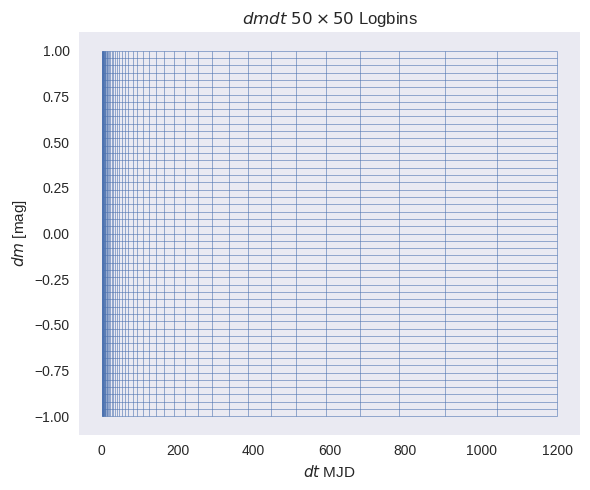

In [4]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 5))

ax.hlines(dm_bins, dt_bins.min(), dt_bins.max(), linewidth=0.4)
ax.vlines(dt_bins, dm_bins.min(), dm_bins.max(), linewidth=0.4)
ax.set_title('$dmdt$ $50 \\times 50$ Logbins')
ax.set_xlabel('$dt$ MJD')
ax.set_ylabel('$dm$ [mag]')

plt.tight_layout()
plt.show()

In [5]:
qso_types = ['Q', 'QR', 'QX']

## Loading up lightcurves

In [6]:
### Loading the lightcurves by name
lightcurves_by_name = pd.read_pickle(base_directory + 'lightcurves_by_name.pkl')
lightcurves_by_name_1day = pd.read_pickle(base_directory + 'lightcurves_by_name_1day_binned.pkl')
lightcurves_by_name = lightcurves_by_name.merge(right=lightcurves_by_name_1day, how='inner', on='name', suffixes=(None, '_1day'))
lightcurves_by_name_1day = np.nan
lightcurves_by_name = lightcurves_by_name.dropna(axis=0)
# lightcurves_by_name = lightcurves_by_name.query("type in @qso_types")
### Sampling to save memory
# lightcurves_by_name = lightcurves_by_name.sample(frac=0.1)

### Loading the lightcurves by OID
lightcurves_by_oid = pd.read_pickle(base_directory + 'lightcurves_by_oid.pkl')
lightcurves_by_oid_1day = pd.read_pickle(base_directory + 'lightcurves_by_oid_1day_binned.pkl')
lightcurves_by_oid = lightcurves_by_oid.merge(right=lightcurves_by_oid_1day, how='inner', on='oid_alerce', suffixes=(None, '_1day'))
lightcurves_by_oid_1day = np.nan
lightcurves_by_oid = lightcurves_by_oid.dropna(axis=0)
# lightcurves_by_oid = lightcurves_by_oid.query("type in @qso_types")
### Sampling to save memory
# lightcurves_by_oid = lightcurves_by_oid.sample(frac=0.1)

In [7]:
def lightcurve2histogram(lightcurve, dm_bins, dt_bins):
    if not isinstance(lightcurve, np.ndarray):
        return np.nan
    histogram, _, _ = get_dmdt_histogram(lightcurve=lightcurve, dmagnitude_bins=dm_bins, dtime_bins=dt_bins)
    return histogram

def return_rg_histograms(r_lightcurve, g_lightcurve, dm_bins, dt_bins):
    r_histogram = lightcurve2histogram(r_lightcurve, dm_bins, dt_bins)
    g_histogram = lightcurve2histogram(g_lightcurve, dm_bins, dt_bins)
    return r_histogram, g_histogram

## Calculating 2D Histograms

In [8]:
# By Name
lightcurves_by_name[['r_histogram', 'g_histogram']] = lightcurves_by_name.parallel_apply(lambda row: return_rg_histograms(row['r_lightcurve'], row['g_lightcurve'], dm_bins, dt_bins), axis=1, result_type='expand')
lightcurves_by_name[['r_histogram_1day', 'g_histogram_1day']] = lightcurves_by_name.parallel_apply(lambda row: return_rg_histograms(row['r_lightcurve_1day'], row['g_lightcurve_1day'], dm_bins, dt_bins), axis=1, result_type='expand')

# By OID
lightcurves_by_oid['histogram'] = lightcurves_by_oid['lightcurve'].parallel_apply(lambda lightcurve: lightcurve2histogram(lightcurve, dm_bins, dt_bins))
lightcurves_by_oid['histogram_1day'] = lightcurves_by_oid['lightcurve_1day'].parallel_apply(lambda lightcurve: lightcurve2histogram(lightcurve, dm_bins, dt_bins))

In [9]:
lightcurves_by_name

,name,type,ra,dec,z,g_timespan_good,g_n_good_det,g_oids,g_lightcurve,r_timespan_good,r_n_good_det,r_oids,r_lightcurve,r_lightcurve_1day,r_n_good_det_1day,r_timespan_good_1day,g_lightcurve_1day,g_n_good_det_1day,g_timespan_good_1day,r_histogram,g_histogram,r_histogram_1day,g_histogram_1day
0,1AXG J000605+2031,AX,1.497482,20.523582,0.38,964.688067,229.0,"[550110200005509, 550110200005509, 55011020000...","[[58268.4661921, 17.2914085, 0.0193178076], [5...",981.708229,222.0,"[550210200011033, 550210200011033, 55021020001...","[[58268.4470486, 17.2935829, 0.0198369212], [5...","[[58268.4470486, 17.2935829, 0.0198369212], [5...",206.0,962.716157,"[[58268.4661921, 17.2914085, 0.0193178076], [5...",211.0,962.670093,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
1,1AXG J035008-1149,AX,57.522460,-11.824012,0.45,376.989526,10.0,"[1344109100000968, 1345112200001061, 134410910...","[[58390.4113657, 19.8996181, 0.129595727], [58...",340.960799,6.0,"[1344209100007817, 1344209100007817, 134521220...","[[58432.3809954, 19.886844600000003, 0.1277610...","[[58432.3809954, 19.886844600000003, 0.1277610...",4.0,316.086638,"[[58390.4113657, 19.8996181, 0.129595727], [58...",5.0,359.060802,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32229,eHAQ0142+0257,QR,25.528603,2.953628,2.31,957.648796,214.0,"[450107400003174, 450107400003174, 45010740000...","[[58298.4827431, 18.9552612, 0.063075698899999...",962.719190,342.0,"[450207400009426, 450207400009426, 45020740000...","[[58301.4430787, 17.906868, 0.0333674327], [58...","[[58301.4430787, 17.906868, 0.0333674327], [58...",184.0,954.707616,"[[58298.4827431, 18.9552612, 0.063075698899999...",192.0,955.648634,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
32230,eHAQ0147+1549,BRX,26.820357,15.828883,0.37,959.672581,416.0,"[553101400000952, 554104300001475, 55310140000...","[[58300.4637847, 19.7455463, 0.107512668], [58...",982.677836,886.0,"[553201400001883, 554204300001931, 55320140000...","[[58288.4649769, 18.7370911, 0.060006402400000...","[[58288.472511600005, 18.733430887729455, 0.04...",306.0,978.665405,"[[58300.4637847, 19.7455463, 0.107512668], [58...",213.0,955.679664,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 175.03286...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."


In [10]:
lightcurves_by_oid

,oid_alerce,name,ra,dec,z,type,band,timespan_good,n_good_det,lightcurve,lightcurve_1day,n_good_det_1day,timespan_good_1day,histogram,histogram_1day
0,202116200001134,[MML2015] 5BZQ J0121-2806,20.253078,-28.106155,3.119,QSO RLoud flat radio sp.,g,91.813565,22,"[[59128.3131713, 19.233299300000002, 0.1209965...","[[59128.3131713, 19.233299300000002, 0.1209965...",21.0,90.791991,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
1,202116200001815,MS 01172-2837,19.898718,-28.358674,0.340,AX,g,91.813565,30,"[[59128.3131713, 16.2171993, 0.0201570522], [5...","[[59128.3131713, 16.2171993, 0.0201570522], [5...",29.0,90.791991,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
116013,1896203200014101,[MML2015] 5BZB J0508+8432,77.176442,84.534606,1.340,BL Lac,r,57.856840,6,"[[58770.3863657, 18.7142582, 0.0609602667], [5...","[[58770.3865914, 18.666448724145795, 0.0415820...",2.0,2.974387,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
116014,1896206400004038,[MML2015] 5BZQ J0702+8549,105.636815,85.831252,1.059,QSO RLoud flat radio sp.,r,62.953692,10,"[[58770.3863657, 17.7530937, 0.0321745723], [5...","[[58770.3865914, 17.78022053522822, 0.02322385...",4.0,57.856389,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."


## Visualising lightcurves by name

In [11]:
def plot_single_subfig(subfig, ncols, row, dm_bins=dm_bins, dt_bins=dt_bins):
    object_name = row['name']
    object_type = row['type']

    r_lightcurve = row['r_lightcurve']
    r_lightcurve_1day = row['r_lightcurve_1day']
    g_lightcurve = row['g_lightcurve']
    g_lightcurve_1day = row['g_lightcurve_1day']

    r_histogram = row['r_histogram']
    g_histogram = row['g_histogram']
    histogram = return_showcase_histogram(r_histogram, g_histogram)

    r_histogram_1day = row['r_histogram_1day']
    g_histogram_1day = row['g_histogram_1day']
    histogram_1day = return_showcase_histogram(r_histogram_1day, g_histogram_1day)

    subfig.suptitle(f'{object_name} | Type: {object_type}', size=16, y=1.02)
    
    axs = subfig.subplots(nrows=1, ncols=ncols)
    subfig.subplots_adjust(wspace=0.3)
    
    draw_lightcurve(ax=axs[0], band='r', lightcurve=r_lightcurve)
    draw_lightcurve(ax=axs[0], band='g', lightcurve=g_lightcurve)
    axs[0].set_title(f'Original Cadence ({r_lightcurve.shape[0]} $r$, {g_lightcurve.shape[0]} $g$ epochs)')

    draw_dmdt_rgb_histogram(ax=axs[1], histogram=histogram, dm_bins=dm_bins, dt_bins=dt_bins)
    axs[1].set_title(f'Histogram from Original Cadence')
    draw_dmdt_rgb_histogram(ax=axs[3], histogram=histogram_1day, dm_bins=dm_bins, dt_bins=dt_bins)
    axs[3].set_title(f'Histogram from 1-Day Cadence')

    draw_lightcurve(ax=axs[2], band='r', lightcurve=r_lightcurve_1day)
    draw_lightcurve(ax=axs[2], band='g', lightcurve=g_lightcurve_1day)
    axs[2].set_title(f'1-Day Cadence ({r_lightcurve_1day.shape[0]} $r$, {g_lightcurve_1day.shape[0]} $g$ epochs)')

    return axs

/tmp/ipykernel_2690/521826451.py:13: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(fontsize=10)
/tmp/ipykernel_2690/521826451.py:13: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(fontsize=10)
/tmp/ipykernel_2690/521826451.py:13: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(fontsize=10)
/tmp/ipykernel_2690/521826451.py:13: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(fontsize=10)
/tmp/ipykernel_2690/521826451.py:13: UserWarning: No artists with labels

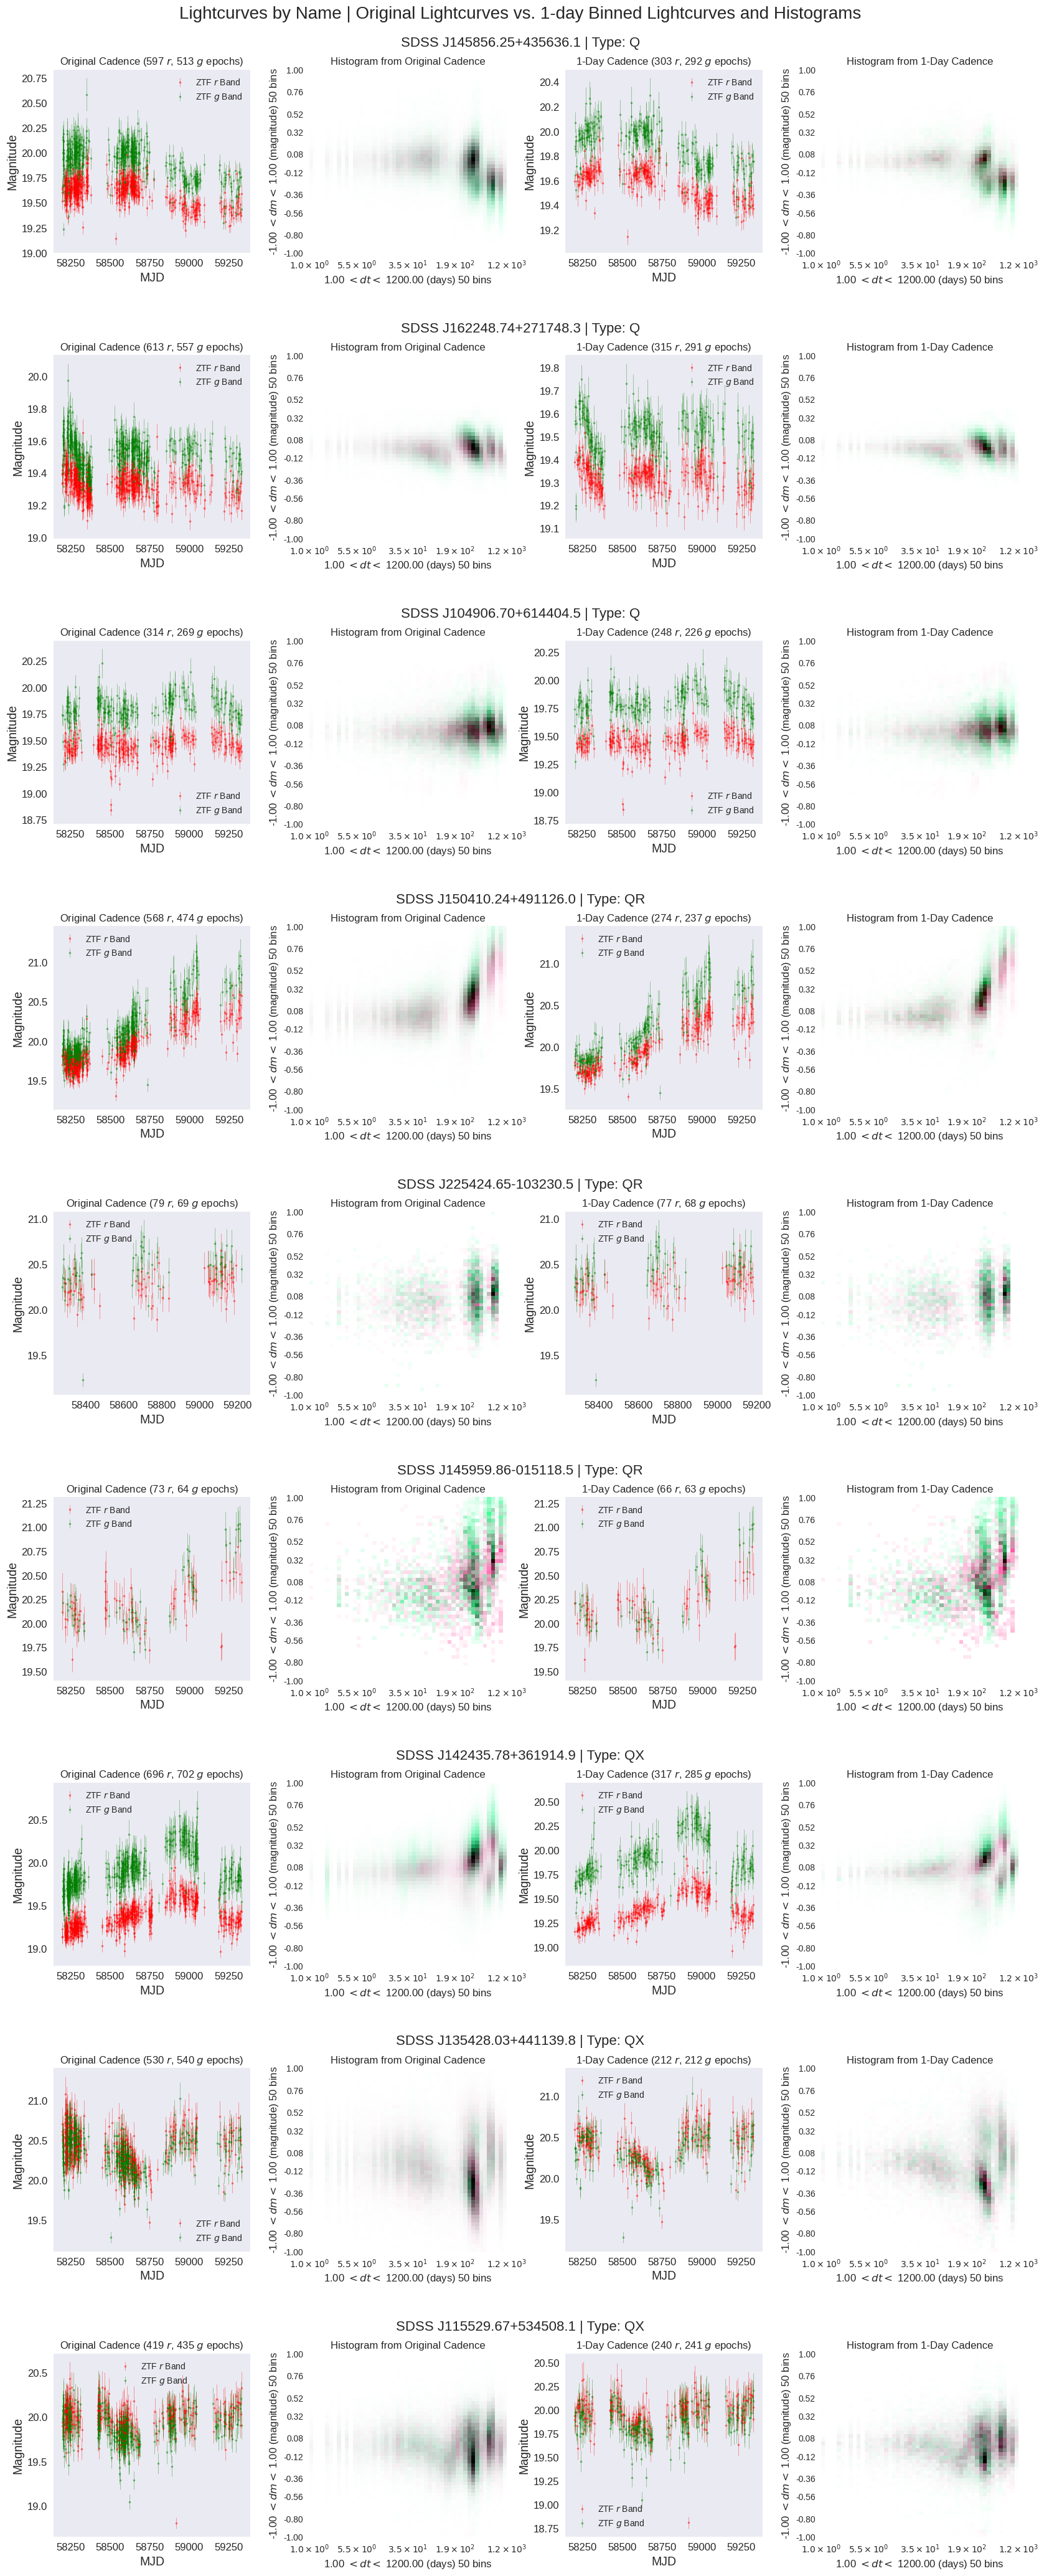

In [12]:
num_examples_per_type = 3
num_examples = num_examples_per_type * 3
sample_df = lightcurves_by_name.query("type in @qso_types")
sample_df = sample_df.groupby('type').sample(num_examples_per_type)

nrows, ncols = num_examples, 4
fig = plt.figure(figsize=(ncols * 5, nrows * 4.5))
subfigs = fig.subfigures(nrows=nrows, ncols=1, hspace=0.2)

for i, (index, row) in enumerate(sample_df.iterrows()):
    axs = plot_single_subfig(subfigs[i], ncols=ncols, row=row, dm_bins=dm_bins, dt_bins=dt_bins)
    for ax in axs:
        ax.legend(fontsize=10)

fig.suptitle('Lightcurves by Name | Original Lightcurves vs. 1-day Binned Lightcurves and Histograms', size=20, y=1.014)

# plt.tight_layout()
plt.show()

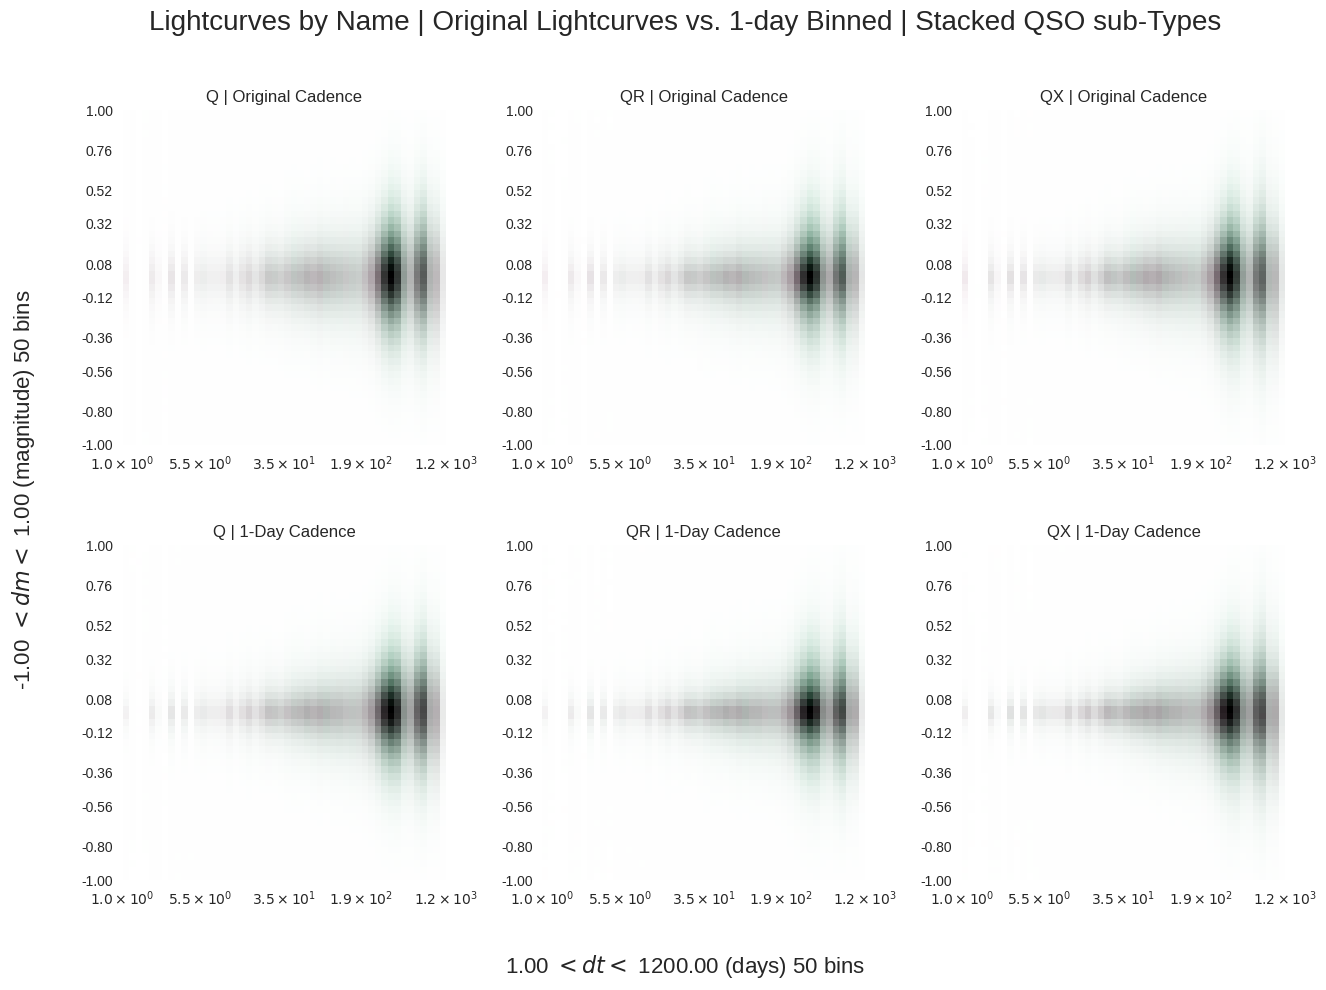

In [13]:
nrows, ncols = 2, 3
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols * 5, nrows * 5))

for object_type, ax_column in zip(qso_types, axs.T):
    r_histogram = lightcurves_by_name.query("type == @object_type")['r_histogram'].dropna(axis=0).apply(norm_0_1).sum()
    g_histogram = lightcurves_by_name.query("type == @object_type")['g_histogram'].dropna(axis=0).apply(norm_0_1).sum()
    r_histogram_1day = lightcurves_by_name.query("type == @object_type")['r_histogram_1day'].dropna(axis=0).apply(norm_0_1).sum()
    g_histogram_1day = lightcurves_by_name.query("type == @object_type")['g_histogram_1day'].dropna(axis=0).apply(norm_0_1).sum()

    showcase_histogram = return_showcase_histogram(r_histogram, g_histogram)
    showcase_histogram_1day = return_showcase_histogram(r_histogram_1day, g_histogram_1day)

    draw_dmdt_rgb_histogram(ax=ax_column[0], histogram=showcase_histogram, dm_bins=dm_bins, dt_bins=dt_bins)
    ax_column[0].set_title(f'{object_type} | Original Cadence')
    draw_dmdt_rgb_histogram(ax=ax_column[1], histogram=showcase_histogram_1day, dm_bins=dm_bins, dt_bins=dt_bins)
    ax_column[1].set_title(f'{object_type} | 1-Day Cadence')

xlabel = axs[0, 0].get_xlabel()
ylabel = axs[0, 0].get_ylabel()
for ax in axs.flatten():
    ax.set_xlabel('')
    ax.set_ylabel('')

fig.suptitle('Lightcurves by Name | Original Lightcurves vs. 1-day Binned | Stacked QSO sub-Types', size=20)
# y=1.014
fig.supxlabel(xlabel, size=16)
fig.supylabel(ylabel, size=16, x=0.05)
fig.subplots_adjust(wspace=0.3, hspace=0.3)
# plt.tight_layout()
plt.show()

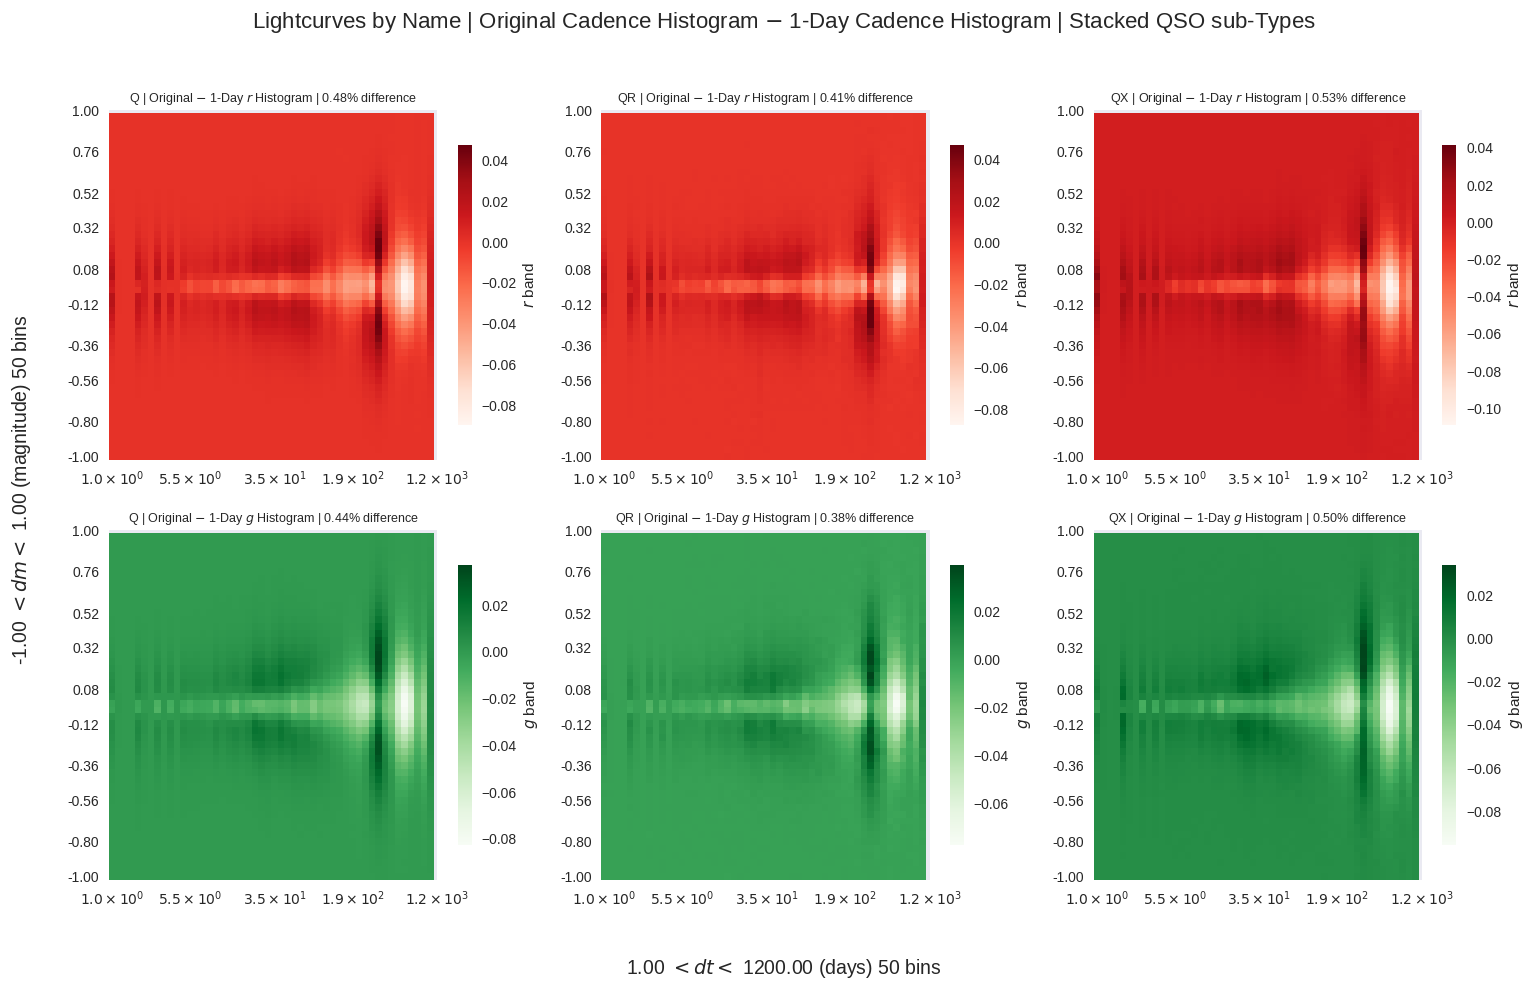

In [14]:
nrows, ncols = 2, 3
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols * 6, nrows * 5))

for object_type, ax_column in zip(qso_types, axs.T):
    r_histogram = norm_0_1(lightcurves_by_name.query("type == @object_type")['r_histogram'].dropna(axis=0).apply(norm_0_1).sum())
    g_histogram = norm_0_1(lightcurves_by_name.query("type == @object_type")['g_histogram'].dropna(axis=0).apply(norm_0_1).sum())
    r_histogram_1day = norm_0_1(lightcurves_by_name.query("type == @object_type")['r_histogram_1day'].dropna(axis=0).apply(norm_0_1).sum())
    g_histogram_1day = norm_0_1(lightcurves_by_name.query("type == @object_type")['g_histogram_1day'].dropna(axis=0).apply(norm_0_1).sum())

    r_difference = r_histogram - r_histogram_1day
    r_sum_differnce = np.abs(r_difference).sum() / np.ones_like(r_difference).sum()
    g_difference = g_histogram - g_histogram_1day
    g_sum_differnce = np.abs(g_difference).sum() / np.ones_like(g_difference).sum()

    draw_single_channel_dmdt_histogram(ax_column[0], r_difference, 'r', dm_bins, dt_bins, cbar=True)
    ax_column[0].set_title(f'{object_type} | Original $-$ 1-Day $r$ Histogram | {r_sum_differnce:.2%} difference', size=9)
    draw_single_channel_dmdt_histogram(ax_column[1], g_difference, 'g', dm_bins, dt_bins, cbar=True)
    ax_column[1].set_title(f'{object_type} | Original $-$ 1-Day $g$ Histogram | {g_sum_differnce:.2%} difference', size=9)

xlabel = axs[0, 0].get_xlabel()
ylabel = axs[0, 0].get_ylabel()
for ax in axs.flatten():
    ax.set_xlabel('')
    ax.set_ylabel('')

fig.suptitle('Lightcurves by Name | Original Cadence Histogram $-$ 1-Day Cadence Histogram | Stacked QSO sub-Types', size=16)
# y=1.014
fig.supxlabel(xlabel, size=14)
fig.supylabel(ylabel, size=14, x=0.07)
fig.subplots_adjust(wspace=0.2, hspace=0.2)
# plt.tight_layout()
plt.show()

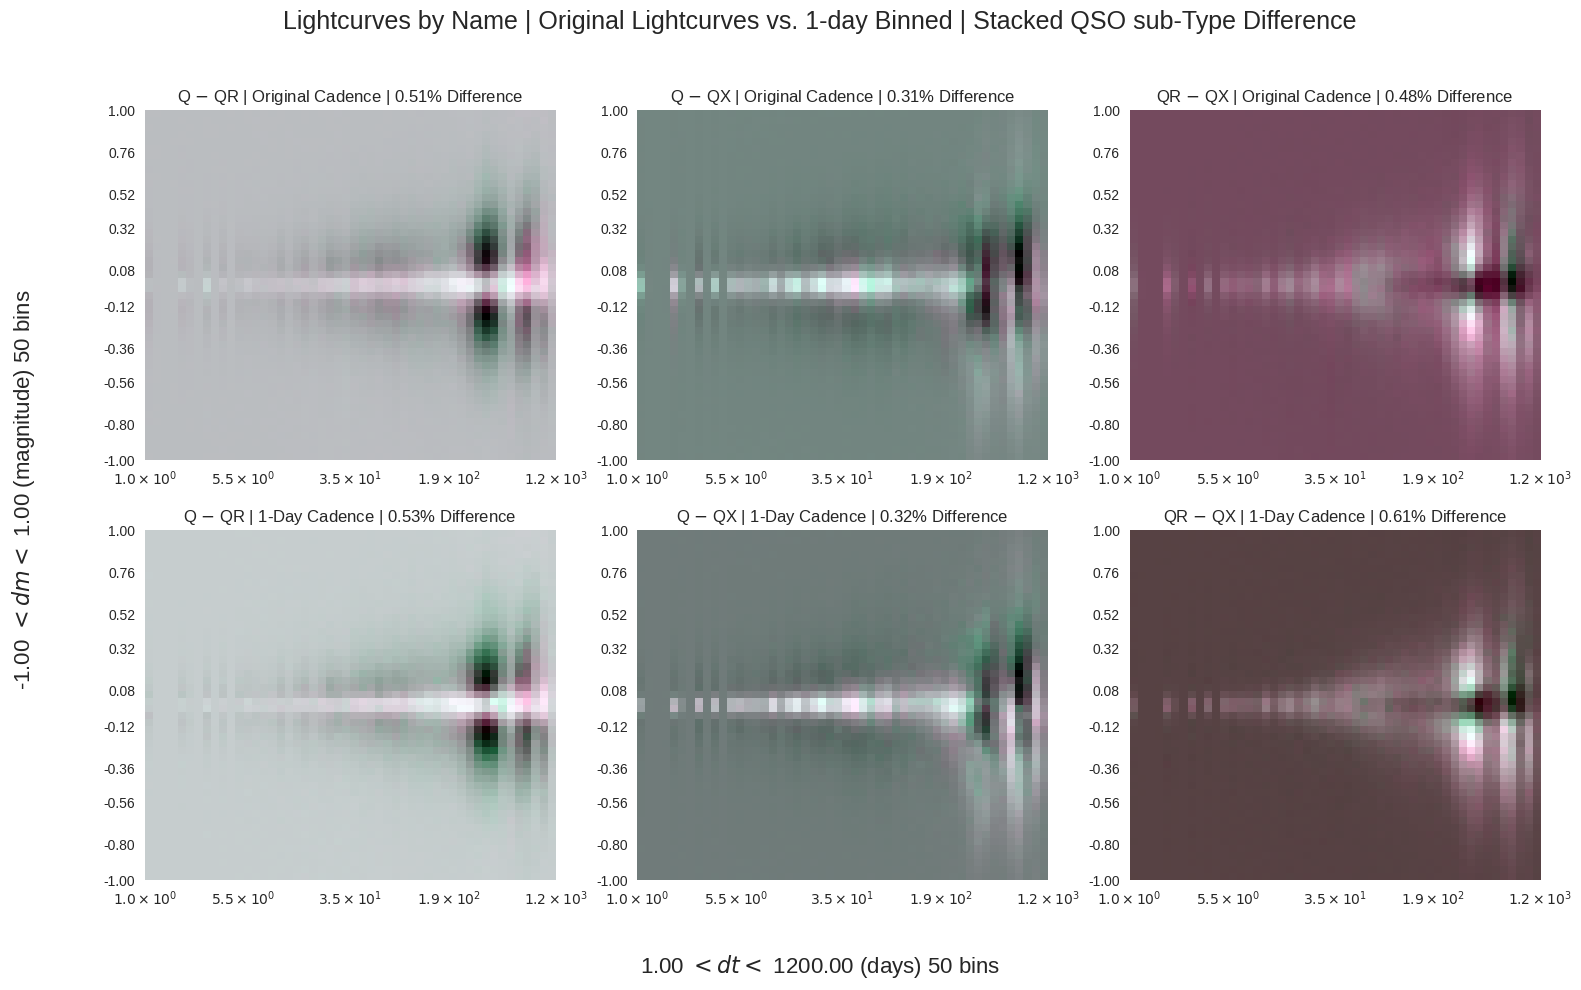

In [15]:
qso_subtype_combinations = [(qso_types[i], qso_types[j]) for i in range(3) for j in range(i + 1, 3)]

nrows, ncols = 2, 3
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols * 6, nrows * 5))

for type_combination, ax_col in zip(qso_subtype_combinations, axs.T):
    type_1, type_2 = type_combination
    
    r_difference = norm_0_1(lightcurves_by_name.query("type == @type_1")['r_histogram'].apply(norm_0_1).sum()) - norm_0_1(lightcurves_by_name.query("type == @type_2")['r_histogram'].apply(norm_0_1).sum())
    g_difference = norm_0_1(lightcurves_by_name.query("type == @type_1")['g_histogram'].apply(norm_0_1).sum()) - norm_0_1(lightcurves_by_name.query("type == @type_2")['g_histogram'].apply(norm_0_1).sum())
    r_difference_1day = norm_0_1(lightcurves_by_name.query("type == @type_1")['r_histogram_1day'].apply(norm_0_1).sum()) - norm_0_1(lightcurves_by_name.query("type == @type_2")['r_histogram_1day'].apply(norm_0_1).sum())
    g_difference_1day = norm_0_1(lightcurves_by_name.query("type == @type_1")['g_histogram_1day'].apply(norm_0_1).sum()) - norm_0_1(lightcurves_by_name.query("type == @type_2")['g_histogram_1day'].apply(norm_0_1).sum())

    sum_differnce = np.abs(np.stack([r_difference, g_difference], axis=0)).sum() / np.ones_like(np.stack([r_difference, g_difference], axis=0)).sum()
    sum_differnce_1day = np.abs(np.stack([r_difference_1day, g_difference_1day], axis=0)).sum() / np.ones_like(np.stack([r_difference_1day, g_difference_1day], axis=0)).sum()

    showcase_histogram = return_showcase_histogram(r_difference, g_difference)
    showcase_histogram_1day = return_showcase_histogram(r_difference_1day, g_difference_1day)

    draw_dmdt_rgb_histogram(ax=ax_col[0], histogram=showcase_histogram, dm_bins=dm_bins, dt_bins=dt_bins)
    ax_col[0].set_title(f'{type_1} $-$ {type_2} | Original Cadence | {sum_differnce:.2%} Difference')
    draw_dmdt_rgb_histogram(ax=ax_col[1], histogram=showcase_histogram_1day, dm_bins=dm_bins, dt_bins=dt_bins)
    ax_col[1].set_title(f'{type_1} $-$ {type_2} | 1-Day Cadence | {sum_differnce_1day:.2%} Difference')

xlabel = axs[0, 0].get_xlabel()
ylabel = axs[0, 0].get_ylabel()
for ax in axs.flatten():
    ax.set_xlabel('')
    ax.set_ylabel('')

fig.suptitle('Lightcurves by Name | Original Lightcurves vs. 1-day Binned | Stacked QSO sub-Type Difference', size=18)
fig.supxlabel(xlabel, size=16)
fig.supylabel(ylabel, size=16, x=0.05)
fig.subplots_adjust(wspace=0.2, hspace=0.2)
# plt.tight_layout()
plt.show()

In [16]:
lightcurves_by_name[['name', 'r_histogram', 'g_histogram', 'r_histogram_1day', 'g_histogram_1day']].to_pickle(base_directory + 'dmdt_Analysis/50x50_dmLin_dtLog_Bins/50x50_dmLin_dtLog_binned_histograms_by_name.pkl')

## By OID

In [17]:
def plot_single_subfig(subfig, ncols, row, dm_bins=dm_bins, dt_bins=dt_bins):
    name = row['name']
    oid = row['oid_alerce']
    object_type = row['type']
    band = row['band']

    lightcurve = row['lightcurve']
    lightcurve_1day = row['lightcurve_1day']
    histogram = row['histogram']
    histogram_1day = row['histogram_1day']

    subfig.suptitle(f'OID: {oid} | Name: {name} | Type: {object_type}', size=16, y=1.02)
    
    axs = subfig.subplots(nrows=1, ncols=ncols)
    subfig.subplots_adjust(wspace=0.4)
    
    draw_lightcurve(ax=axs[0], band=band, lightcurve=lightcurve)
    axs[0].set_title(f'Original Cadence ({lightcurve.shape[0]} ${band}$ epochs)')

    draw_single_channel_dmdt_histogram(ax=axs[1], histogram=histogram, band=band, dm_bins=dm_bins, dt_bins=dt_bins, cbar=True)
    axs[1].set_title(f'Histogram from Original Cadence')
    draw_single_channel_dmdt_histogram(ax=axs[3], histogram=histogram_1day, band=band, dm_bins=dm_bins, dt_bins=dt_bins, cbar=True)
    axs[3].set_title(f'Histogram from 1-Day Cadence')

    draw_lightcurve(ax=axs[2], band=band, lightcurve=lightcurve_1day)
    axs[2].set_title(f'1-Day Cadence ({lightcurve_1day.shape[0]} $r$ epochs)')

    return axs

/tmp/ipykernel_2690/2668815678.py:13: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(fontsize=10)
/tmp/ipykernel_2690/2668815678.py:13: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(fontsize=10)
/tmp/ipykernel_2690/2668815678.py:13: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(fontsize=10)
/tmp/ipykernel_2690/2668815678.py:13: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(fontsize=10)
/tmp/ipykernel_2690/2668815678.py:13: UserWarning: No artists with l

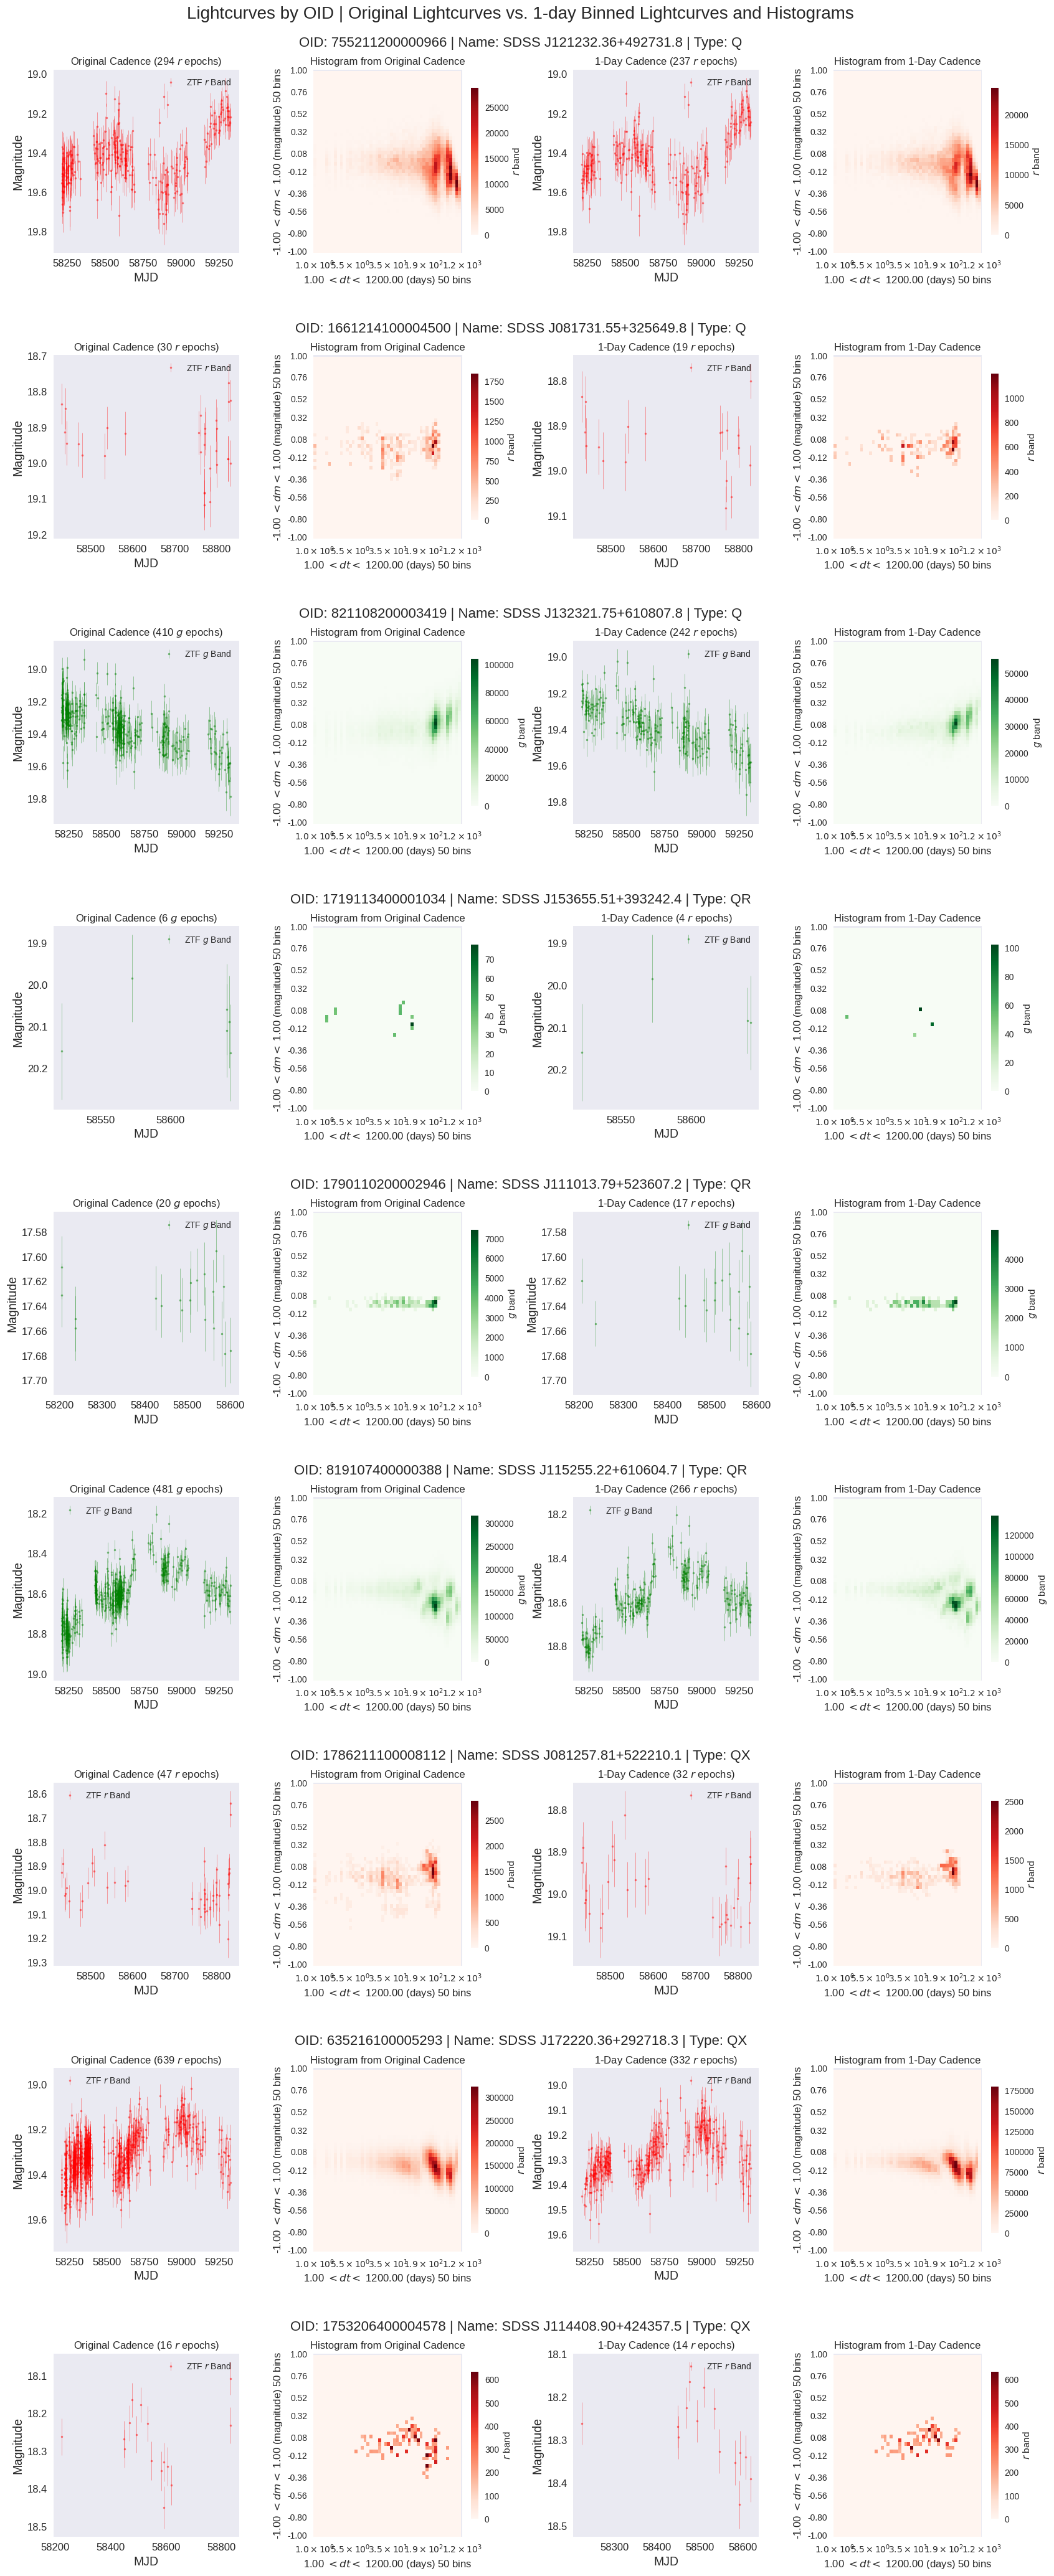

In [18]:
num_examples_per_type = 3
num_examples = num_examples_per_type * 3
sample_df = lightcurves_by_oid.query("type in @qso_types")
sample_df = sample_df.groupby('type').sample(num_examples_per_type)

nrows, ncols = num_examples, 4
fig = plt.figure(figsize=(ncols * 5, nrows * 4.5))
subfigs = fig.subfigures(nrows=nrows, ncols=1, hspace=0.2)

for i, (index, row) in enumerate(sample_df.iterrows()):
    axs = plot_single_subfig(subfigs[i], ncols=ncols, row=row, dm_bins=dm_bins, dt_bins=dt_bins)
    for ax in axs:
        ax.legend(fontsize=10)

fig.suptitle('Lightcurves by OID | Original Lightcurves vs. 1-day Binned Lightcurves and Histograms', size=20, y=1.014)

# plt.tight_layout()
plt.show()

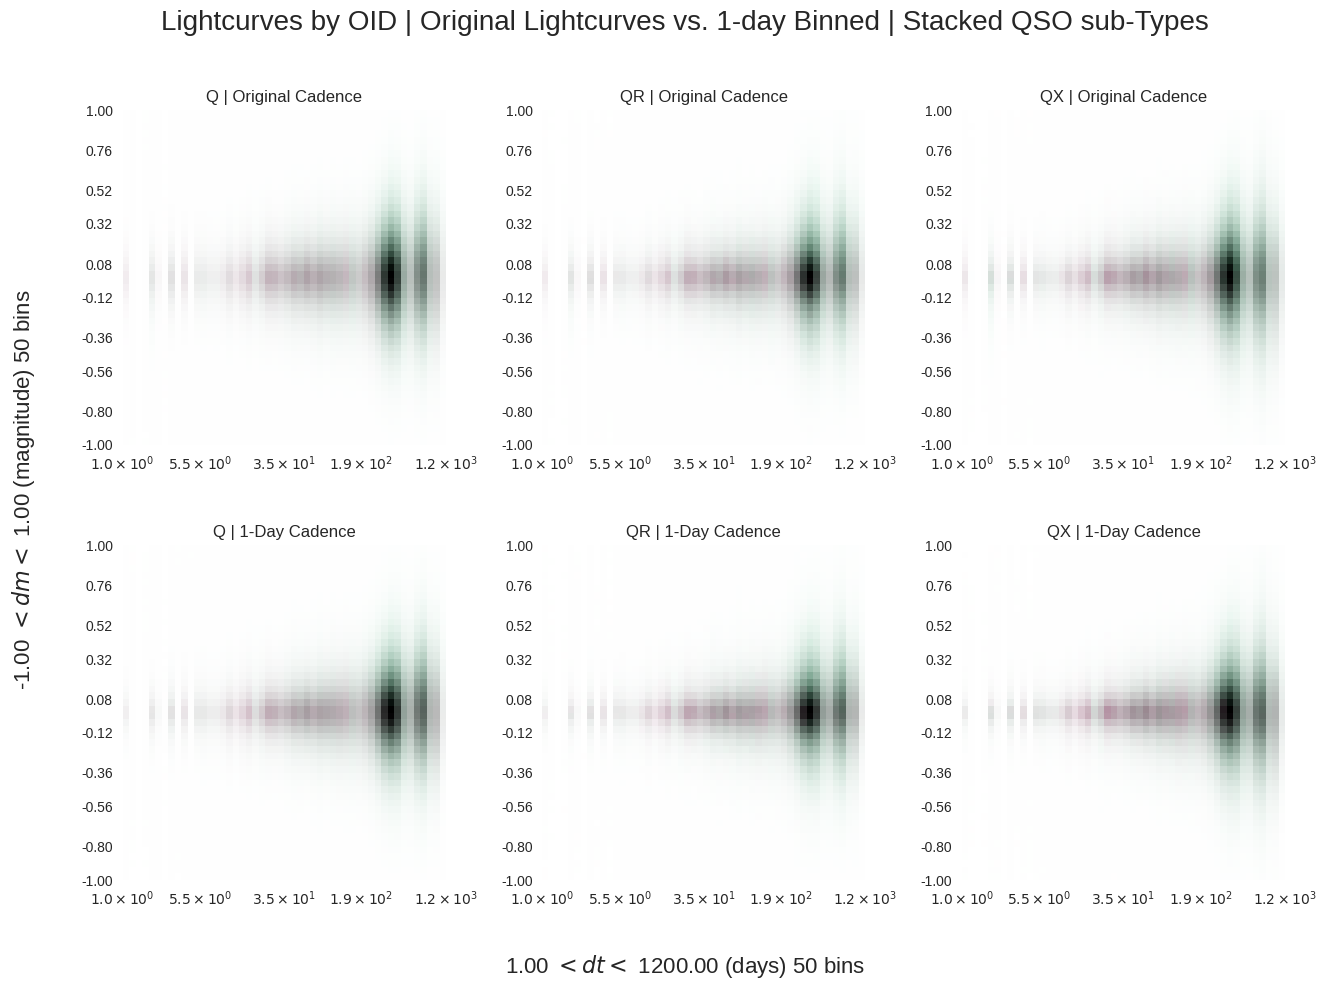

In [19]:
nrows, ncols = 2, 3
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols * 5, nrows * 5))

for object_type, ax_column in zip(qso_types, axs.T):
    r_histogram = lightcurves_by_oid.query("type == @object_type and band=='r'")['histogram'].apply(norm_0_1).sum()
    g_histogram = lightcurves_by_oid.query("type == @object_type and band=='g'")['histogram'].apply(norm_0_1).sum()
    r_histogram_1day = lightcurves_by_oid.query("type == @object_type and band=='r'")['histogram_1day'].apply(norm_0_1).sum()
    g_histogram_1day = lightcurves_by_oid.query("type == @object_type and band=='g'")['histogram_1day'].apply(norm_0_1).sum()
    
    showcase_histogram = return_showcase_histogram(r_histogram, g_histogram)
    showcase_histogram_1day = return_showcase_histogram(r_histogram_1day, g_histogram_1day)

    draw_dmdt_rgb_histogram(ax=ax_column[0], histogram=showcase_histogram, dm_bins=dm_bins, dt_bins=dt_bins)
    ax_column[0].set_title(f'{object_type} | Original Cadence')
    draw_dmdt_rgb_histogram(ax=ax_column[1], histogram=showcase_histogram_1day, dm_bins=dm_bins, dt_bins=dt_bins)
    ax_column[1].set_title(f'{object_type} | 1-Day Cadence')

xlabel = axs[0, 0].get_xlabel()
ylabel = axs[0, 0].get_ylabel()
for ax in axs.flatten():
    ax.set_xlabel('')
    ax.set_ylabel('')

fig.suptitle('Lightcurves by OID | Original Lightcurves vs. 1-day Binned | Stacked QSO sub-Types', size=20)
# y=1.014
fig.supxlabel(xlabel, size=16)
fig.supylabel(ylabel, size=16, x=0.05)
fig.subplots_adjust(wspace=0.3, hspace=0.3)
# plt.tight_layout()
plt.show()

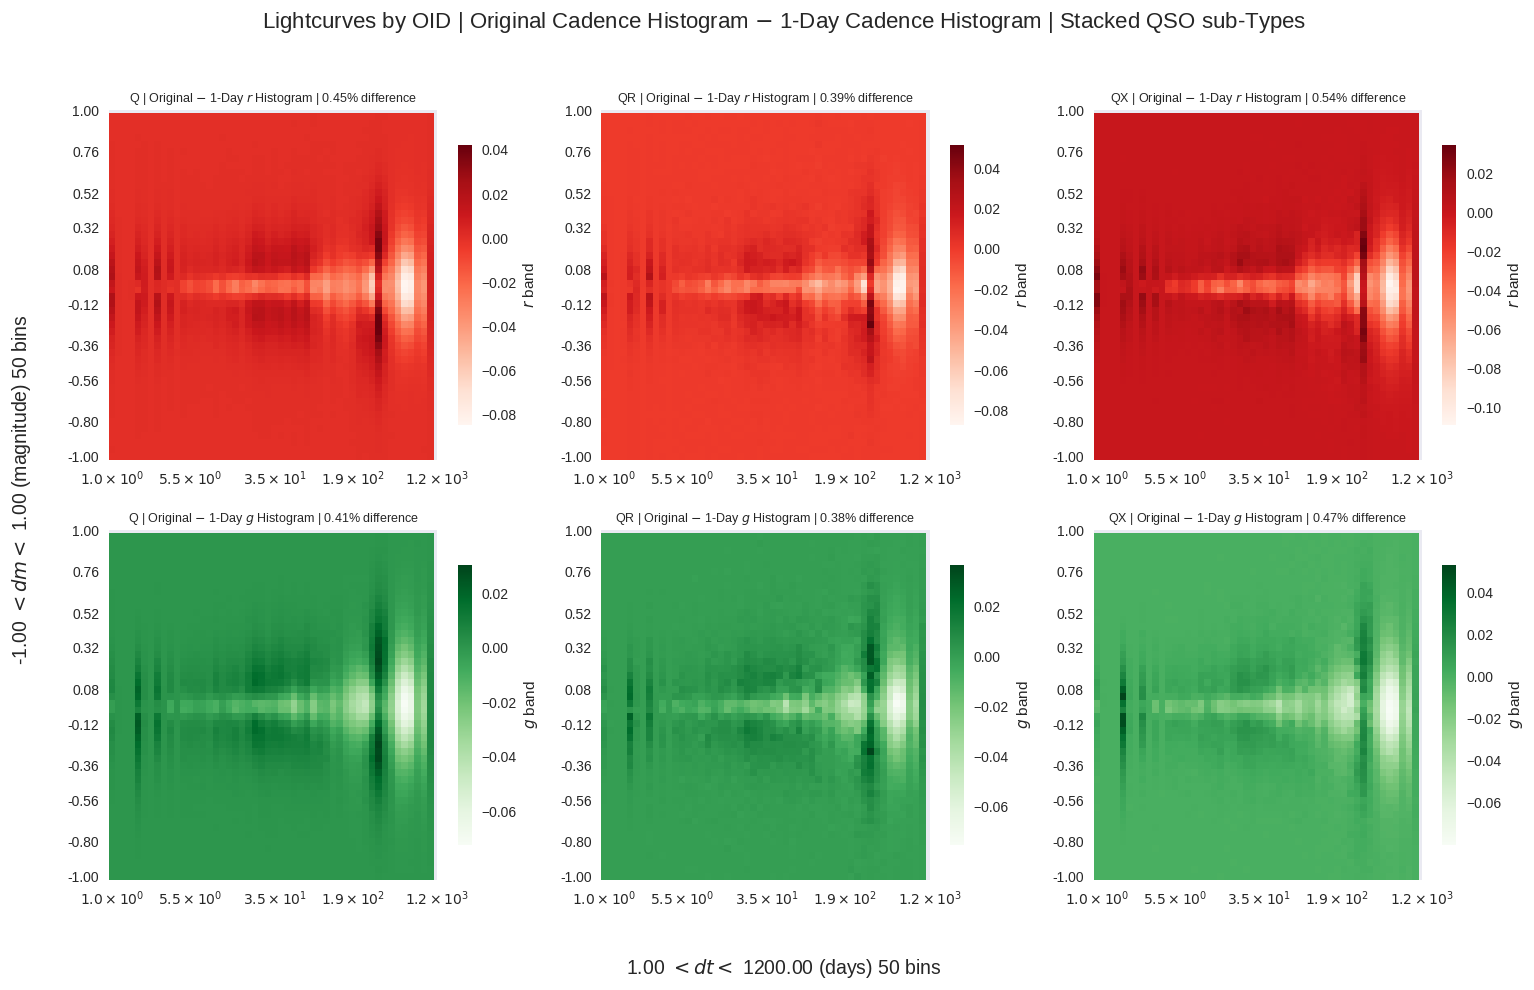

In [20]:
nrows, ncols = 2, 3
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols * 6, nrows * 5))

for object_type, ax_column in zip(qso_types, axs.T):
    r_histogram = norm_0_1(lightcurves_by_oid.query("type == @object_type and band=='r'")['histogram'].apply(norm_0_1).sum())
    g_histogram = norm_0_1(lightcurves_by_oid.query("type == @object_type and band=='g'")['histogram'].apply(norm_0_1).sum())
    r_histogram_1day = norm_0_1(lightcurves_by_oid.query("type == @object_type and band=='r'")['histogram_1day'].apply(norm_0_1).sum())
    g_histogram_1day = norm_0_1(lightcurves_by_oid.query("type == @object_type and band=='g'")['histogram_1day'].apply(norm_0_1).sum())

    r_difference = r_histogram - r_histogram_1day
    r_sum_differnce = np.abs(r_difference).sum() / np.ones_like(r_difference).sum()
    g_difference = g_histogram - g_histogram_1day
    g_sum_differnce = np.abs(g_difference).sum() / np.ones_like(g_difference).sum()

    draw_single_channel_dmdt_histogram(ax_column[0], r_difference, 'r', dm_bins, dt_bins, cbar=True)
    ax_column[0].set_title(f'{object_type} | Original $-$ 1-Day $r$ Histogram | {r_sum_differnce:.2%} difference', size=9)
    draw_single_channel_dmdt_histogram(ax_column[1], g_difference, 'g', dm_bins, dt_bins, cbar=True)
    ax_column[1].set_title(f'{object_type} | Original $-$ 1-Day $g$ Histogram | {g_sum_differnce:.2%} difference', size=9)

xlabel = axs[0, 0].get_xlabel()
ylabel = axs[0, 0].get_ylabel()
for ax in axs.flatten():
    ax.set_xlabel('')
    ax.set_ylabel('')

fig.suptitle('Lightcurves by OID | Original Cadence Histogram $-$ 1-Day Cadence Histogram | Stacked QSO sub-Types', size=16)
# y=1.014
fig.supxlabel(xlabel, size=14)
fig.supylabel(ylabel, size=14, x=0.07)
fig.subplots_adjust(wspace=0.2, hspace=0.2)
# plt.tight_layout()
plt.show()

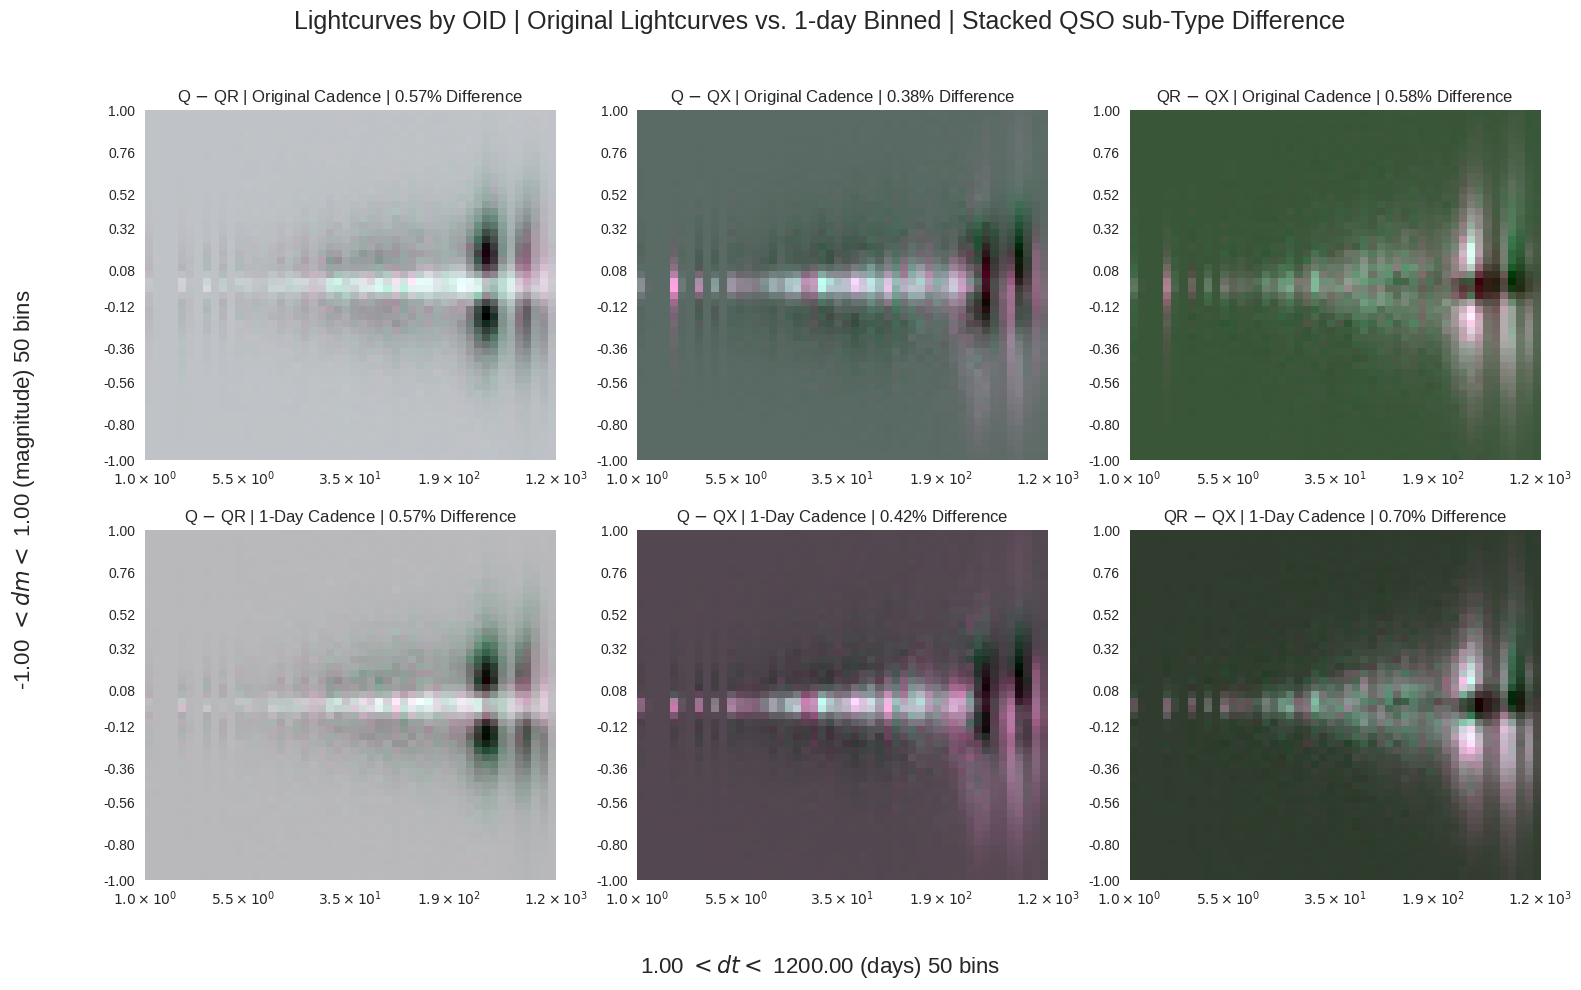

In [21]:
qso_subtype_combinations = [(qso_types[i], qso_types[j]) for i in range(3) for j in range(i + 1, 3)]

nrows, ncols = 2, 3
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols * 6, nrows * 5))

for type_combination, ax_col in zip(qso_subtype_combinations, axs.T):
    type_1, type_2 = type_combination
    
    r_difference = norm_0_1(lightcurves_by_oid.query("type == @type_1 and band=='r'")['histogram'].apply(norm_0_1).sum()) - norm_0_1(lightcurves_by_oid.query("type == @type_2 and band=='r'")['histogram'].apply(norm_0_1).sum())
    g_difference = norm_0_1(lightcurves_by_oid.query("type == @type_1 and band=='g'")['histogram'].apply(norm_0_1).sum()) - norm_0_1(lightcurves_by_oid.query("type == @type_2 and band=='g'")['histogram'].apply(norm_0_1).sum())
    r_difference_1day = norm_0_1(lightcurves_by_oid.query("type == @type_1 and band=='r'")['histogram_1day'].apply(norm_0_1).sum()) - norm_0_1(lightcurves_by_oid.query("type == @type_2 and band=='r'")['histogram_1day'].apply(norm_0_1).sum())
    g_difference_1day = norm_0_1(lightcurves_by_oid.query("type == @type_1 and band=='g'")['histogram_1day'].apply(norm_0_1).sum()) - norm_0_1(lightcurves_by_oid.query("type == @type_2 and band=='g'")['histogram_1day'].apply(norm_0_1).sum())

    sum_differnce = np.abs(np.stack([r_difference, g_difference], axis=0)).sum() / np.ones_like(np.stack([r_difference, g_difference], axis=0)).sum()
    sum_differnce_1day = np.abs(np.stack([r_difference_1day, g_difference_1day], axis=0)).sum() / np.ones_like(np.stack([r_difference_1day, g_difference_1day], axis=0)).sum()

    showcase_histogram = return_showcase_histogram(r_difference, g_difference)
    showcase_histogram_1day = return_showcase_histogram(r_difference_1day, g_difference_1day)

    draw_dmdt_rgb_histogram(ax=ax_col[0], histogram=showcase_histogram, dm_bins=dm_bins, dt_bins=dt_bins)
    ax_col[0].set_title(f'{type_1} $-$ {type_2} | Original Cadence | {sum_differnce:.2%} Difference')
    draw_dmdt_rgb_histogram(ax=ax_col[1], histogram=showcase_histogram_1day, dm_bins=dm_bins, dt_bins=dt_bins)
    ax_col[1].set_title(f'{type_1} $-$ {type_2} | 1-Day Cadence | {sum_differnce_1day:.2%} Difference')

xlabel = axs[0, 0].get_xlabel()
ylabel = axs[0, 0].get_ylabel()
for ax in axs.flatten():
    ax.set_xlabel('')
    ax.set_ylabel('')

fig.suptitle('Lightcurves by OID | Original Lightcurves vs. 1-day Binned | Stacked QSO sub-Type Difference', size=18)
fig.supxlabel(xlabel, size=16)
fig.supylabel(ylabel, size=16, x=0.05)
fig.subplots_adjust(wspace=0.2, hspace=0.2)
# plt.tight_layout()
plt.show()

In [22]:
lightcurves_by_oid[['oid_alerce', 'histogram', 'histogram_1day']].to_pickle(base_directory + 'dmdt_Analysis/50x50_dmLin_dtLog_Bins/50x50_dmLin_dtLog_binned_histograms_by_oid.pkl')